In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mglearn

%matplotlib inline

In [9]:
# define data
charge_eu = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_eu.csv", encoding='utf-8-sig')
charge_na = pd.read_csv("D:\creditCardFraudDetection_data/20170314_charge_na.csv", encoding='utf-8-sig')
purchase_eu = pd.read_csv("D:\creditCardFraudDetection_data/20170411_purchase_eu.csv", encoding='utf-8-sig')
purchase_na = pd.read_csv("D:\creditCardFraudDetection_data/20170411_purchase_eu.csv", encoding='utf-8-sig')

In [10]:
def createAbuserDataSet(data_set):
    data_set = data_set[data_set.charge_status >= 60].drop_duplicates(['user_no'], keep='last')
        
    data_set = pd.DataFrame(data_set, columns=['user_no'])
    data_set['Class'] = 1
    return data_set
def createAllDataSet(data_set):
    data_set = pd.DataFrame(data_set, columns=['user_no']).drop_duplicates(['user_no'], keep='last')
    return data_set

eu 일반 유저의 수:  228078
na 일반 유저의 수:  130860
eu 환불 유저의 수:  726
na 환불 유저의 수:  921
전체 유저의 수:  360585
일반 유저의 비율:  0.9954324223137402
환불 유저의 비율:  0.004567577686259827


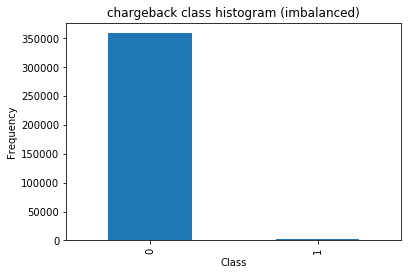

In [11]:
# 데이터 통합 및 일반 유저와 환불 유저의 비율
charge_eu_abuser = createAbuserDataSet(charge_eu)
charge_na_abuser = createAbuserDataSet(charge_na)

# 전체 유저에서 환불 유저를 뺀 것이 일반 유저
charge_eu_normal = createAllDataSet(charge_eu).drop(charge_eu_abuser.index)
charge_eu_normal['Class'] = 0
charge_na_normal = createAllDataSet(charge_na).drop(charge_na_abuser.index)
charge_na_normal['Class'] = 0
print("eu 일반 유저의 수: ", len(charge_eu_normal))
print("na 일반 유저의 수: ", len(charge_na_normal))
print("eu 환불 유저의 수: ", len(charge_eu_abuser))
print("na 환불 유저의 수: ", len(charge_na_abuser))

# 데이터 통합
charge_all = pd.concat([charge_eu_abuser, charge_eu_normal, charge_na_abuser, charge_na_normal])
print("전체 유저의 수: ", len(charge_all))
print("일반 유저의 비율: ", len(charge_all[charge_all.Class == 0]) / len(charge_all))
print("환불 유저의 비율: ", len(charge_all[charge_all.Class == 1]) / len(charge_all))
count_classes = pd.value_counts(charge_all['Class'], sort=True)
count_classes.plot(kind = 'bar')
plt.title("chargeback class histogram (imbalanced)")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [91]:
# feature 생성 과정 (parameter = transaction list) _ original featurel들의 kind 계산
def createFeatureForKind(transactions, charges):
    transactions = transactions[transactions.charge_status == 30]
    list = [[],[],[],[]]

    for user_id in charges.user_no:
        sample = transactions[transactions.user_no == user_id]
        list[0].append(len(sample.drop_duplicates(['standard_country_code'])))
        list[1].append(len(sample.drop_duplicates(['payment_method_no'])))
        list[2].append(len(sample.drop_duplicates(['hash_ip'])))
        list[3].append(len(sample.drop_duplicates(['charge_product_name'])))
          
    charge_all['standard_country_code_kind'] = list[0]
    charge_all['payment_method_no_kind'] = list[1]
    charge_all['hash_ip_kind'] = list[2]
    charge_all['charge_product_name_kind'] = list[3]

In [196]:
transaction_charge = pd.concat([charge_eu, charge_na])
createFeature(transaction_charge, charge_all)
charge_all.to_csv('charge_all.csv')

In [311]:
# 저장된 charge_all 데이터 읽어오기
charge_all = pd.read_csv('charge_all.csv', encoding='utf-8-sig')

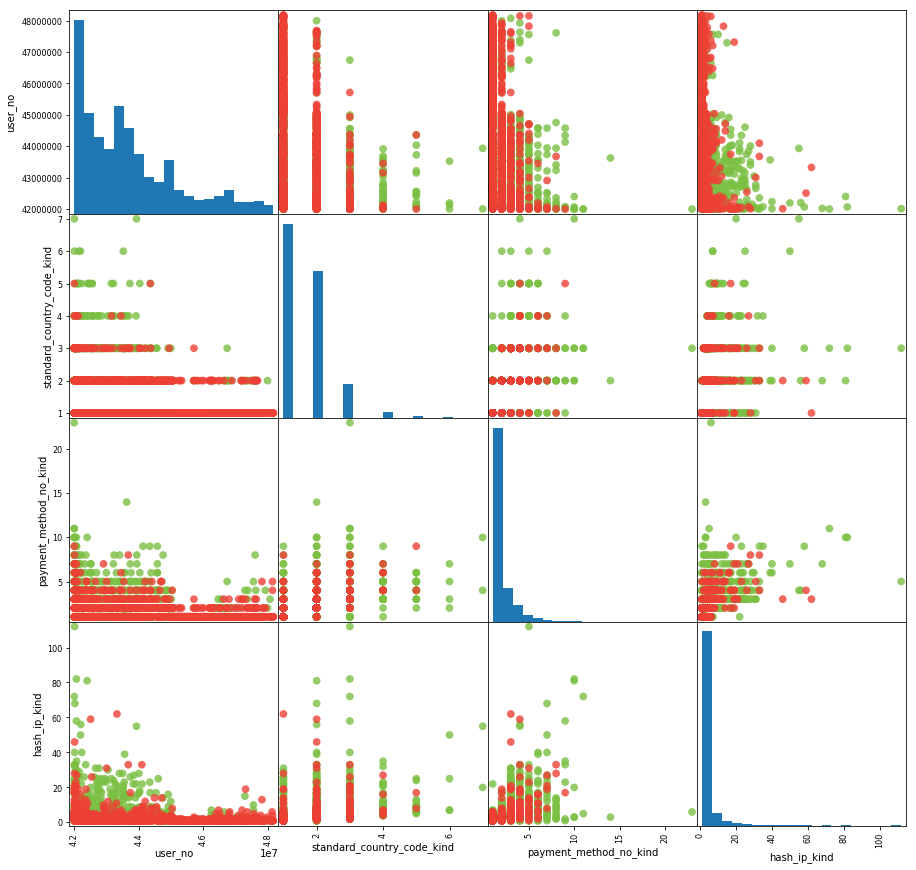

In [202]:
x_train_feature = x_train.iloc[:, 2:6]

color_wheel = {1: "#ee4035", 
               2: "#7bc043" }
colors = y_train["Class"].map(lambda x: color_wheel.get(x + 1))

ax = pd.plotting.scatter_matrix(x_train_feature, color=colors, figsize=(15, 15), marker="o", 
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

In [92]:
# amount(charge, bonus), transaction 수를 위한 feature 생성
def createFeatureForAmount(transactions, charges):
    transactions = transactions[transactions.charge_status == 30]
    list = [[],[],[],[],[],[],[]]

    for user_id in charges.user_no:
        sample = transactions[transactions.user_no == user_id]
        list[0].append(np.sum(sample.iloc[:, 6]))
        list[1].append(np.mean(sample.iloc[:, 6]))
        list[2].append(np.std(sample.iloc[:, 6]))
        list[3].append(np.sum(sample.iloc[:, 7]))
        list[4].append(np.mean(sample.iloc[:, 7]))
        list[5].append(np.std(sample.iloc[:, 7]))         
        list[6].append(len(sample.iloc[:, 7]))         
        
    charge_all['charge_amount_sum'] = list[0]
    charge_all['charge_amount_avg'] = list[1]
    charge_all['charge_amount_stddev'] = list[2]
    charge_all['bonus_amount_sum'] = list[3]
    charge_all['bonus_amount_avg'] = list[4]
    charge_all['bonus_amount_stddev'] = list[5]
    charge_all['transaction_cnt_sum'] = list[6]

In [236]:
transaction_charge = pd.concat([charge_eu, charge_na])
createFeatureForAmount(transaction_charge, charge_all)
charge_all_sample.iloc[:, 7:14] = charge_all_sample.iloc[:, 7:14].astype(np.float)

In [239]:
charge_all.iloc[:, 7:14] = charge_all.iloc[:, 7:14].astype(np.float)

In [240]:
charge_all.to_csv('charge_all2.csv')

In [50]:
# 저장된 charge_all 데이터 읽어오기
charge_all = pd.read_csv('charge_all2.csv', encoding='utf-8-sig')

In [51]:
# under sampling 과정
number_abuser = len(charge_all[charge_all.Class == 1])
abuser_indices = charge_all[charge_all.Class == 1].index
normal_indices = charge_all[charge_all.Class == 0].index

random_normal_indices = np.random.choice(normal_indices, number_abuser, replace = False)
random_normal_indices = np.array(random_normal_indices)

charge_all_sample_indices = np.concatenate([abuser_indices, random_normal_indices])

charge_all_sample = charge_all.iloc[charge_all_sample_indices, :]

x_train = charge_all_sample.iloc[:, charge_all_sample.columns != 'Class']
y_train = charge_all_sample.iloc[:, charge_all_sample.columns == 'Class']

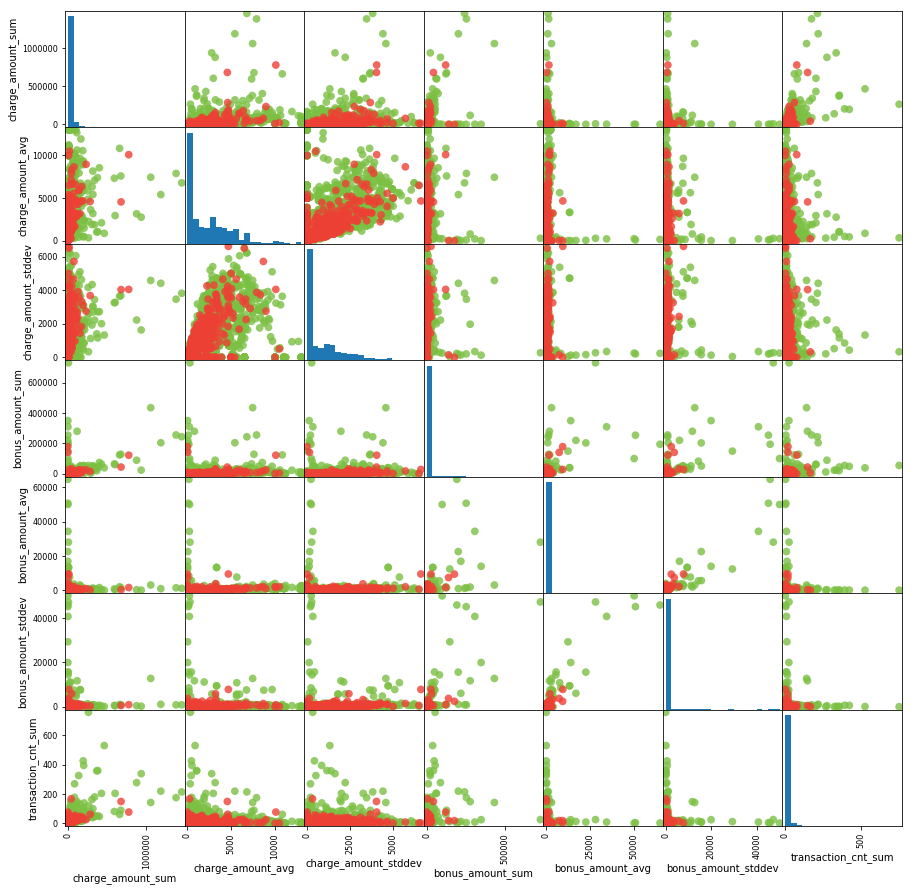

In [35]:
x_train2 = charge_all_sample.iloc[:, charge_all_sample.columns != 'Class']
y_train2 = charge_all_sample.iloc[:, charge_all_sample.columns == 'Class']
x_train_feature2 = x_train2.iloc[:, 4:11]

color_wheel = {1: "#ee4035", 
               2: "#7bc043" }
colors = y_train2["Class"].map(lambda x: color_wheel.get(x + 1))

ax = pd.plotting.scatter_matrix(x_train_feature2, color=colors, figsize=(15, 15), marker="o", 
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

In [35]:
def getTime(date):
    date = date.replace("-", " ")
    dates = date.split(" ")
    year = dates[0]
    month = dates[1]
    day = dates[2]
    hour = dates[3]
    return str(year), str(month), str(day), str(hour)

def getRangeDate(year, month, day, num):
    m = int(month) - int(num)
    y = year
    d = day
    if m <= 0 :
        m = 12 + int(m)
        y = int(y) - 1
    return str(y), str(m), str(d)

# 마지막 feature들을 생성 (transaction 수와 관련된 feature들)
def createFeatureForTransaction(transactions):
    transactions = transactions[transactions.charge_status == 30]
    list = [[],[],[],[],[]]
    
    for user_id in charge_all_sample.user_no:
        samples = transactions[transactions.user_no == user_id]
        samples = samples.sort_values(by=['charge_datetime'], ascending=False)
        isFirst = True
        lYear, lMonth, lDay, countList = [0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0,0]
        pYear, pMonth, pDay = [0,0,0,0],[0,0,0,0],[0,0,0,0]
        #print(samples)
        for date in samples['charge_datetime']:
            year, month, day, hour = getTime(date)
            if len(month) != 2: month = '0' + month  
            if isFirst:
                lYear[0], lMonth[0], lDay[0] = year, month, day
                lYear[1], lMonth[1], lDay[1] = getRangeDate(lYear[0], lMonth[0], lDay[0], '01')
                lYear[2], lMonth[2], lDay[2] = getRangeDate(lYear[1], lMonth[1], lDay[1], '02')
                lYear[3], lMonth[3], lDay[3] = getRangeDate(lYear[2], lMonth[2], lDay[2], '03')
                pYear[0], pMonth[0], pDay[0] = lYear[1], lMonth[1], lDay[1]
                pYear[1], pMonth[1], pDay[1] = lYear[2], lMonth[2], lDay[2]
                pYear[2], pMonth[2], pDay[2] = lYear[3], lMonth[3], lDay[3]
                pYear[3], pMonth[3], pDay[3] = getRangeDate(lYear[3], lMonth[3], lDay[3], '06')
                isFirst = False
                for i in range(0, 4):
                    if len(pMonth[i]) != 2: pMonth[i] = '0' + pMonth[i]
                    if len(lMonth[i]) != 2: lMonth[i] = '0' + lMonth[i]
                continue
            for i in range(0, 4):
                pValue = int(pYear[i] + pMonth[i] + pDay[i])
                cValue = int(year + month + day)
                lValue = int(lYear[i] + lMonth[i] + lDay[i])
                
                #print(pValue, cValue, lValue, i)
                if pValue <= cValue <= lValue :
                    countList[i] = countList[i] + 1
                    break
        sum = 0
        for i in range(0, 4):
            sum += countList[i]
        countList[4] = len(samples['charge_datetime']) - sum ;
        #print(countList[0], countList[1],countList[2], countList[3], countList[4])
        
        for i in range(0, 5):
            list[i].append(countList[i])
        
    charge_all_sample['tran_cnt_1_month'] = list[0]
    charge_all_sample['tran_cnt_2_month'] = list[1]
    charge_all_sample['tran_cnt_3_month'] = list[2]
    charge_all_sample['tran_cnt_6_month'] = list[3]
    charge_all_sample['tran_cnt_else'] = list[4]

In [52]:
transaction_charge = pd.concat([charge_eu, charge_na])
createFeatureForTransaction(transaction_charge)

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [54]:
# 필요없는 key들 drop 과정
charge_all_sample = charge_all_sample.drop(charge_all_sample.columns[0:4], axis=1)

In [55]:
charge_all_sample.iloc[:, 3:] = charge_all_sample.iloc[:, 3:].astype(np.float)

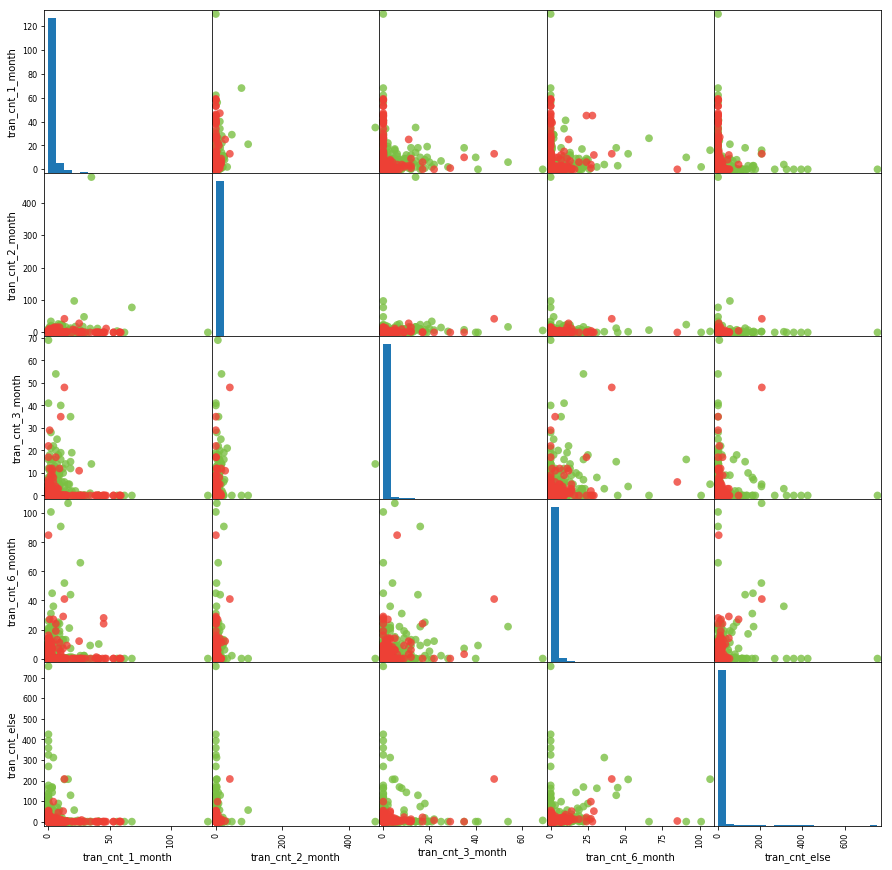

In [62]:
x_train3 = charge_all_sample.iloc[:, charge_all_sample.columns != 'Class']
y_train3 = charge_all_sample.iloc[:, charge_all_sample.columns == 'Class']
x_train_feature3 = x_train3.iloc[:, 11:16]

color_wheel = {1: "#ee4035", 
               2: "#7bc043" }
colors = y_train3["Class"].map(lambda x: color_wheel.get(x + 1))

ax = pd.plotting.scatter_matrix(x_train_feature3, color=colors, figsize=(15, 15), marker="o", 
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

In [86]:
# sample data modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split

X = charge_all_sample.iloc[:, charge_all_sample.columns != 'Class']
y = charge_all_sample.iloc[:, charge_all_sample.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = RandomForestClassifier(n_estimators=100, random_state=2)
#model = svm.LinearSVC()
#model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print("훈련 세트 정확도: {:.3f}".format(model.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(model.score(X_test, y_test)))

C:\Users\jgb710\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


훈련 세트 정확도: 0.994
테스트 세트 정확도: 0.892


In [87]:
model.feature_importances_

array([ 0.01,  0.02,  0.02,  0.02,  0.28,  0.23,  0.06,  0.09,  0.09,
        0.04,  0.04,  0.05,  0.01,  0.01,  0.01,  0.03])

In [83]:
from sklearn.metrics import precision_score, f1_score, recall_score
y_pred = model.predict(X_test)
print("precision- score: {}".format(precision_score(y_test, y_pred)))
print("recall- score: {}".format(recall_score(y_test, y_pred)))
print("f1- score: {}".format(f1_score(y_test, y_pred)))

precision- score: 0.8189300411522634
recall- score: 0.9128440366972477
f1- score: 0.8633405639913233


In [72]:
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.912844036697


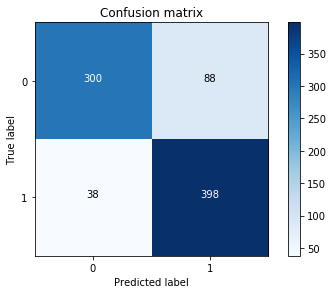

In [84]:
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

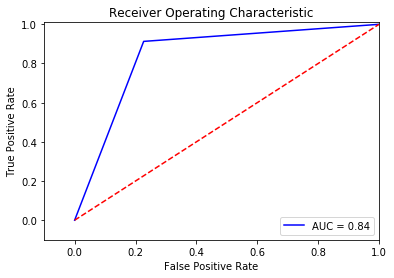

In [85]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()